Nenwin-project (NEural Networks WIthout Neurons) for
the AI Honors Academy track 2020-2021 at the TU Eindhoven.

Authors: Lulof Pirée

May 2021

Copyright (C) 2021 Lulof Pirée

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Banknote dataset with Nenwin

Dataset source: https://code.datasciencedojo.com/datasciencedojo/datasets/blob/master/Banknote%20Authentication/data_banknote_authentication.txt
See also:
* https://jamesmccaffrey.wordpress.com/2020/08/18/in-the-banknote-authentication-dataset-class-0-is-genuine-authentic/
* https://www.researchgate.net/publication/266673146_Banknote_Authentication

This dataset has:
* 1372 samples, of two classes:
    * class 0 (Genuine): 762 samples 
    * class 1 (Forgery): 610 samples

Features:
* 0: variance (float)
* 1: skewness (float)
* 2: curtosis (float)
* 3: entropy  (float)


**Goal**: classify which banknotes are real and which ones are forgeries,

based on the four features (that are derived from an image, using the 'Wavelet Transform").

In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Iterable
from numbers import Number

from nenwin.constants import BANKNOTE_CHECKPOINT_DIR
from nenwin.all_particles import Marble, Node, MarbleEmitterNode, MarbleEaterNode
from nenwin.model import NenwinModel
from nenwin.input_placer import InputPlacer
from nenwin.grid_input_placer import VelInputPlacer
from nenwin.attraction_functions.attraction_functions import NewtonianGravity, AttractionFunction
from nenwin.backprop.filename_gen import FilenameGenerator
from nenwin.backprop.trainer import NenwinTrainer
from nenwin.backprop.training_stats import TrainingStats
from nenwin.backprop.loss_function import NenwinLossFunction
from nenwin.banknote_dataset.load_dataset import load_banknote_dataset, BanknoteDataset
from nenwin.creation_functions import gen_nodes, gen_eater_nodes
from nenwin.plot_model import plot_model

## Architecture generation

In [2]:
def gen_architecture() -> Tuple[NenwinModel, VelInputPlacer, Tuple[Node]]:
    """
    Generate the following architecture:
    * The input region is at (-2.5, -1) and has size (5, 2) 
        (So it has vertices {(-2.5, -1), (-2.5, 1), (2.5, -1), (2.5, 1)})
    * There are two MarbleEaterNodes, at (-10, 0) and (10, 0)
    * There are four normal Nodes, at (0, -5), (-5, 0), (5, 0) and (0, 5).

    Returns:
    * Model holding the architecture descibed above
    * VelInputPlacer with the input region as described above.
    * Tuple of the two MarbleEaterNodes
    """

    eater_positions = [(-10, 0), (10, 0)]
    node_positions = [(0, -5), (-5, 0), (5, 0), (0, 5)]
    input_region_pos = np.array((-2.5, -1))
    input_region_size = np.array((5, 2))
    mass = 1
    radius = 0.5

    attraction_function = NewtonianGravity()

    nodes = gen_nodes(attraction_function, mass, node_positions)
    eater_nodes = gen_eater_nodes(attraction_function, mass, 
                                  radius, eater_positions)
    model = NenwinModel(nodes+eater_nodes)
    input_placer = VelInputPlacer(input_region_pos, input_region_size)

    return model, input_placer, eater_nodes

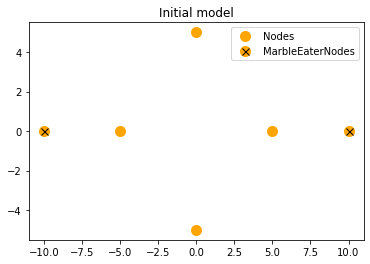

In [3]:
MODEL, INPUT_PLACER, EATERS = gen_architecture()
ax = plot_model(MODEL)
ax.set_title("Initial model");

## Training setup

In [4]:
LOSS_POS_WEIGHT = 1
LOSS_VEL_WEIGHT = 1
DATASET = load_banknote_dataset()
train_set = tuple(DATASET.iter_train())
train_set[0][0]

array([[1.4884 , 3.6274 , 3.308  , 0.48921]])

In [5]:
def create_trainer(model: NenwinModel,
                   input_placer: InputPlacer,
                   output_nodes: Iterable[MarbleEaterNode],
                   dataset: BanknoteDataset,
                   loss_pos_weight: float,
                   loss_vel_weight: float) -> NenwinTrainer:

    loss_funct = NenwinLossFunction(output_nodes, model, loss_vel_weight,
                                    loss_pos_weight)
    optim = torch.optim.Adam(model.parameters())
    filename_gen = FilenameGenerator(BANKNOTE_CHECKPOINT_DIR, "BANKNOTE_", ".txt")
    trainer = NenwinTrainer(model, loss_funct, optim, filename_gen,
                            input_placer, dataset)
    return trainer

TRAINER = create_trainer(MODEL, 
                         INPUT_PLACER, 
                         EATERS,
                         DATASET,
                         loss_pos_weight= LOSS_POS_WEIGHT,
                         loss_vel_weight = LOSS_VEL_WEIGHT)

In [6]:
num_epochs = 20
step_size = 0.1
num_steps_till_read_output = int(2 / step_size)
do_validate = True
checkpoint_interval = 100

TRAINER.run_training(num_epochs,
                    step_size,
                    num_steps_till_read_output,
                    do_validate,
                    checkpoint_interval)

Last epoch 0 finished: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_Thu_May_13_16-50-52_2021.txt


In [7]:
stats = TRAINER.training_stats
stats

In [8]:
stats.train_losses

(72712.35063934326,)

In [9]:
stats.validation_accuracies

(0.0,)

In [10]:
MODEL, INPUT_PLACER, EATERS = gen_architecture()
ax = plot_model(MODEL)
ax.set_title("Trained model");

{MarbleEaterNode(tensor([-9.2527, -0.4918]),tensor([ 0.7474, -0.4918]),tensor([ 0.7474, -0.4918]),1.1331239938735962,NewtonianGravity(),1.0,1.0,1.0,0.0,0.5),
 MarbleEaterNode(tensor([9.3660, 0.5246]),tensor([-0.6349,  0.5261]),tensor([-0.6349,  0.5261]),0.8645471930503845,NewtonianGravity(),1.0,1.0,0.8645471930503845,0.0,0.5),
 Node(tensor([ 5.1200, -0.2177]),tensor([0., 0.]),tensor([0., 0.]),0.8738136887550354,NewtonianGravity(),1.0,1.0,0.8738136887550354,0.0),
 Node(tensor([-0.0860, -4.8476]),tensor([0., 0.]),tensor([0., 0.]),1.1403918266296387,NewtonianGravity(),1.0,1.0,1.0,0.0),
 Node(tensor([-0.1658,  5.0403]),tensor([0., 0.]),tensor([0., 0.]),0.9326843619346619,NewtonianGravity(),1.0,1.0,0.9326843619346619,0.0),
 Node(tensor([-4.8763,  0.0294]),tensor([0., 0.]),tensor([0., 0.]),1.1247845888137817,NewtonianGravity(),1.0,1.0,1.0,0.0)}

## Loading a saved model
To confirm the saving works. 
No point in training a model if it is lost immediately after!

In [14]:
filename = "/home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_Thu_May_13_16-50-52_2021.txt"
import torch.tensor as tensor
from nenwin.attraction_functions.attraction_functions import ThresholdGravity
with open(filename, "r") as file:
    model = eval(file.readline())

<AxesSubplot:>

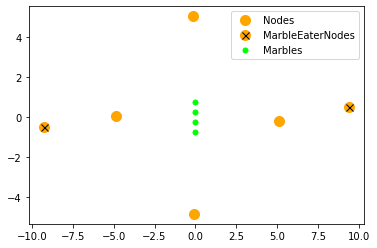

In [17]:
plot_model(model)